# Import Libraries:

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector
import os

import warnings
warnings.filterwarnings('ignore')

# Connect Mysql with Python

In [ ]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Mysql@2023",
                            database = "ecommerce")

cur = db.cursor()

# Basic Queries

# 1. List all unique cities where customers are located.


In [25]:
query = """select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [11]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [17]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items on 
products.product_id = order_items.product_id
join payments on
payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [21]:
query = """select (sum(case when payment_installments >= 1 then 1
else 0 end))/ count(*)*100 from payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is:", data[0][0]

('the percentage of orders that were paid in installments is:',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

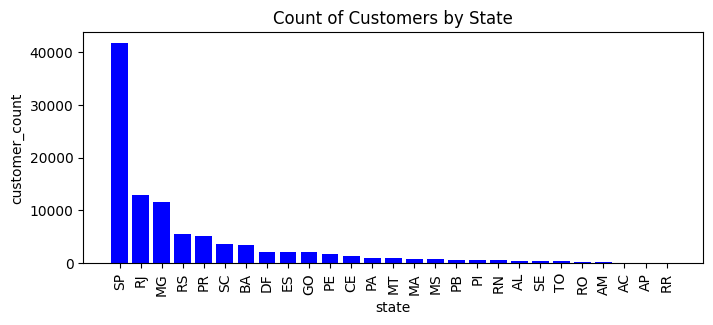

In [122]:
query = """select customer_state,count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count",ascending=False)
plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"],color= 'blue')
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title('Count of Customers by State' )
plt.xticks(rotation=90)
plt.show()

# Intermediate Queries

# 1. Calculate the number of orders per month in 2018.

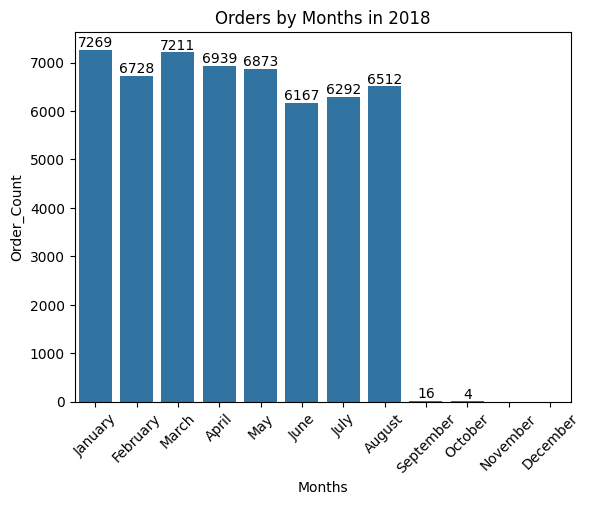

In [40]:
query = """select monthname(order_purchase_timestamp) months ,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Months","Order_Count"])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax = sns.barplot(x='Months',y = 'Order_Count',data=df,order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Orders by Months in 2018")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [46]:
query = """with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_City_Name","Average_Product/Orders"])
df.head(10)

,Customer_City_Name,Average_Product/Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [49]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value)/ (select sum(payment_value) from payments)*100 ,2)
sales_percentages
from products join order_items on 
products.product_id = order_items.product_id
join payments on
payments.order_id = order_items.order_id
group by category order by sales_percentages desc

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Percentage Distribution"])
df.head()

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [59]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Order_Count","Price"])
correlation = df['Order_Count'].corr(df['Price'])
print("Correlation between Order_Count and Price is:",correlation)

Correlation between Order_Count and Price is: -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

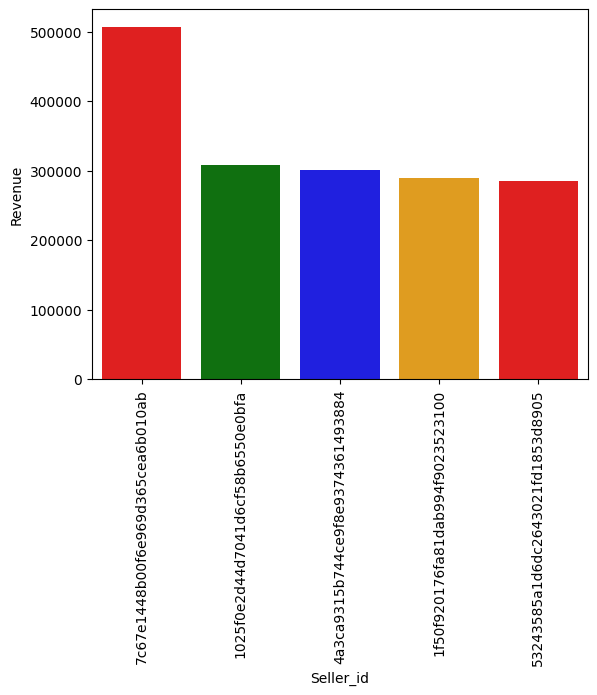

In [121]:
query = """ select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Seller_id','Revenue','Rank'])
df= df.head()
custom_colors = ['red', 'green', 'blue', 'orange']
sns.barplot(x = 'Seller_id',y = 'Revenue',data= df,palette = custom_colors)
plt.xticks(rotation = 90)
plt.show()

# Advanced Queries

# 1. Calculate the moving average of order values for each customer over their order history.

In [76]:
query = """ select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Order_id','Timestamp','Avg_Order_Value','Moving_Avg_Order_Value'])
df.head()

,Order_id,Timestamp,Avg_Order_Value,Moving_Avg_Order_Value
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 2. Calculate the cumulative sales per month for each year.

In [82]:
query = """ select years,months,payment,sum(payment) 
over(order by years ,months) cumulative_sales 
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months) as a

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Years','Months','Sales','Cumulative_Sales'])
df.head(5)
                                   

,Years,Months,Sales,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


Text(0.5, 1.0, 'Cumulative Sales vs Year')

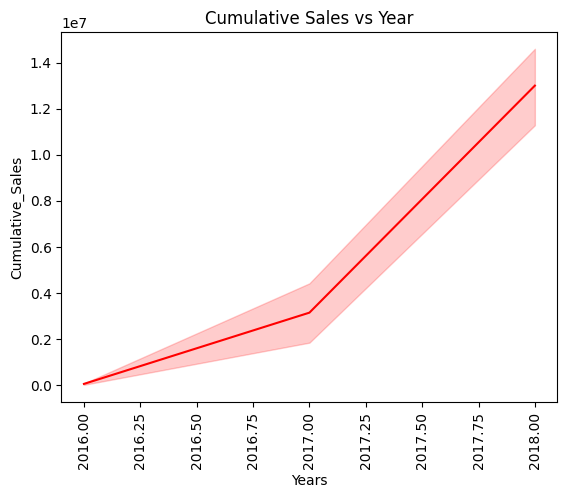

In [90]:
sns.lineplot(data=df,x='Years',y = 'Cumulative_Sales',color = 'red')
plt.xticks(rotation = 90)
plt.title("Cumulative Sales vs Year")

# 3. Calculate the year-over-year growth rate of total sales.

In [99]:
query = """with a as( select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years))/ 
lag(payment,1) over(order by years))*100 from a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Years','YoY_%_Growth'])
df


,Years,YoY_%_Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [106]:
query = """ with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct(orders.order_purchase_timestamp))
from a join orders on
orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and  orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100* (count(distinct a.customer_id)/count(distinct(b.customer_id)))
from a left join b
on a.customer_id = b.customer_id

"""
cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

In [113]:
query = """ select years,customer_id,payment,d_rank 
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc ) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank<=3

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ["Years","Id","Payment","Rank" ])
df.head()

,Years,Id,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2


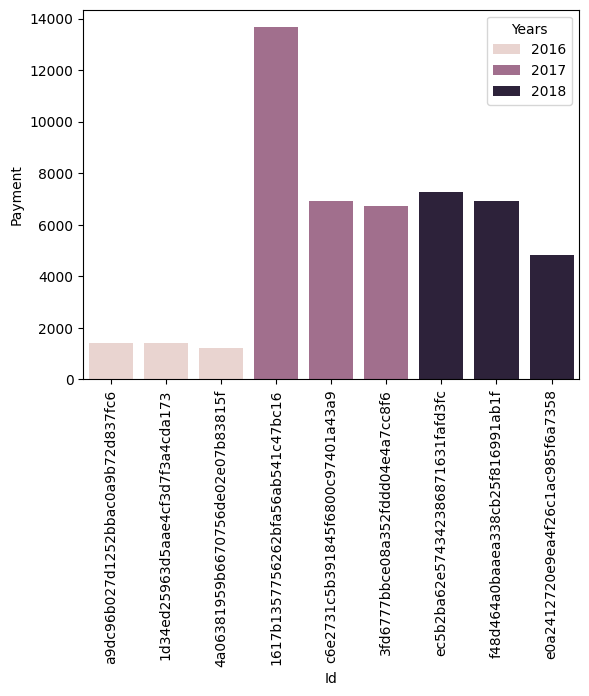

In [117]:
sns.barplot(x = 'Id',y = 'Payment',data = df,hue = 'Years')
plt.xticks(rotation = 90)
plt.show()